In [1]:
import ROOT                                                                                                             
import uproot                                                                                                           
import uproot.behaviors.TGraph                                                                                          
import uproot3                                                                                                          
import os                                                                                                               
import csv                                                                                                              
import pandas as pd                                                                                                     
import numpy as np                                                                                                      
import multiprocessing as mp                                                                                            
import awkward as ak                                                                                                    
import matplotlib.pyplot as plt  
import matplotlib 
import seaborn as sns                                                                                                   
from tools.binnings_collection import get_nbins_in_range, get_sub_binning, get_bin_center, compute_dayfromtime          
from tools.binnings_collection import mass_binning, fbinning_energy, LithiumRigidityBinningFullRange, Rigidity_Analysis_Binning_FullRange                                                                                                      
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE_BIG, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle                                                                                                                  
from tools.calculator import calc_rig_from_ekin, calc_ratio_err, calc_ekin_from_beta, calc_mass                         
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS ,  ISOTOPES_COLOR, ISO_LABELS, DETECTOR_LABEL, DETECTOR_COLOR  
from tools.constants import ANALYSIS_RANGE_EKIN
from tools.histograms import Histogram, plot_histogram_2d                                                               
from tools.binnings import Binning                                                                                      
from tools.roottree import read_tree                                                                                    
from tools.selections import *                                                                                                                                                                                                   
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.MassFunction_V2 import expo_func                                                                                                                                                                                                       
from tools.massfunction_TofGBLV2 import TofInverseMassFunctionFit                                                                                                                                                                                 
from tools.massfunction_NaFGBLV2 import NaFInverseMassFunctionFit                                                                                                                                                                                 
from tools.massfunction_AglGBLV2 import AglInverseMassFunctionFit 
from tools.setplotstyle import set_plot_style
from tools.statistics import lafferty_whyatt, row_mean_and_std, approximate_upper_poisson_error, approximate_lower_poisson_error, calculate_ratioerrs 

Welcome to JupyROOT 6.26/10


In [2]:
figsize1 = (25, 22)
fontsize1 = 45
fontsize2 = 55
mksize = 30
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_FitDataPars_BeP8'
datadir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitDataGBL_Rebin'
os.makedirs(plotfile, exist_ok=True) 


In [3]:
with open(os.path.join(datadir, 'FitData_ResultsPars.pickle'), 'rb') as file:
    dict_results = pickle.load(file) 

In [4]:
filedata = '/home/manbing/Documents/Data/data_BeP8/BeMassHist/BeISS_masshist_EkinP8GBL_Rebin.npz'
nuclei = 'Be'
detectors = ['Tof', 'NaF', 'Agl']
isotopes = ISOTOPES[nuclei]
hist2d_mass_energy = {}
fit_range_mass_nuclei = [0.055, 0.22]
MassFunctionFit = {"Tof": TofInverseMassFunctionFit, "NaF": NaFInverseMassFunctionFit, "Agl": AglInverseMassFunctionFit}
with np.load(filedata) as massfile:                                                                                                                                                                                                          
    for dec in detectors:                                                                                                                                                                                                                                                                                                                                                                                                                          
        hist2d_mass_energy[dec]= Histogram.from_file(massfile, f"Be_{dec}OptBe7_mass_ciemat")  
        
massfit = {}
RANGE_EKIN ={"Tof": [0.5, 1.1], "NaF": [1.2, 4.0], "Agl": [4.0, 12.0]}
for dec in detectors:
    massfit[dec] = MassFunctionFit[dec](isotopes, hist2d_mass_energy[dec], RANGE_EKIN[dec], fit_range_mass_nuclei, dec, True)



0 3
[0.4631  0.559   0.66835 0.79125 0.9303  1.08555]
0 3
[1.2571  1.44745 1.6566  1.8872  2.1419  2.42075 2.7237  3.0534  3.4126
 3.80125]
0 3
[ 3.80125  4.2221   4.67795  5.16875  5.70575  6.27195  6.8673   7.52005
  8.2303   8.99805  9.82325 10.7059  11.64595]


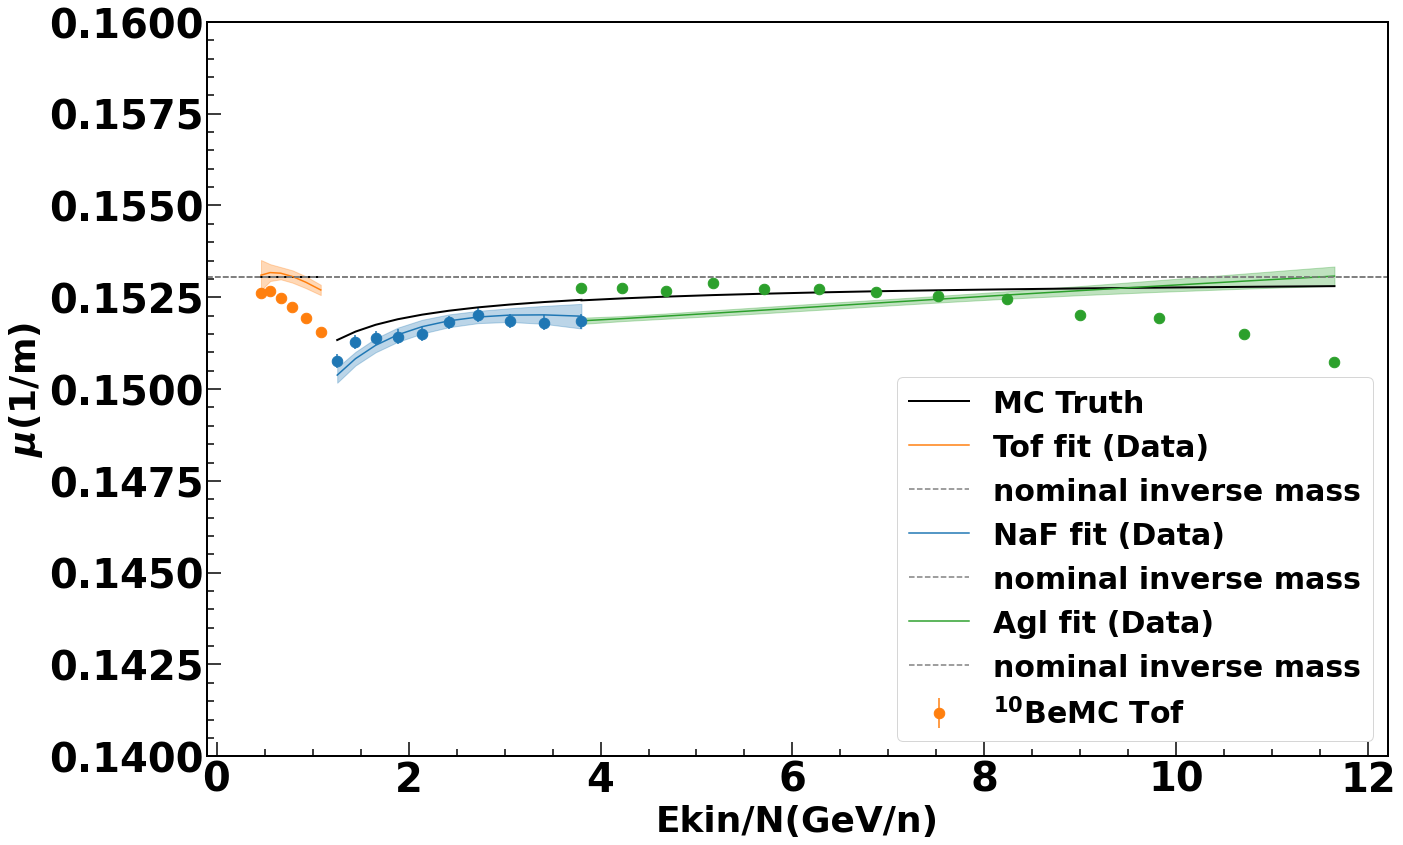

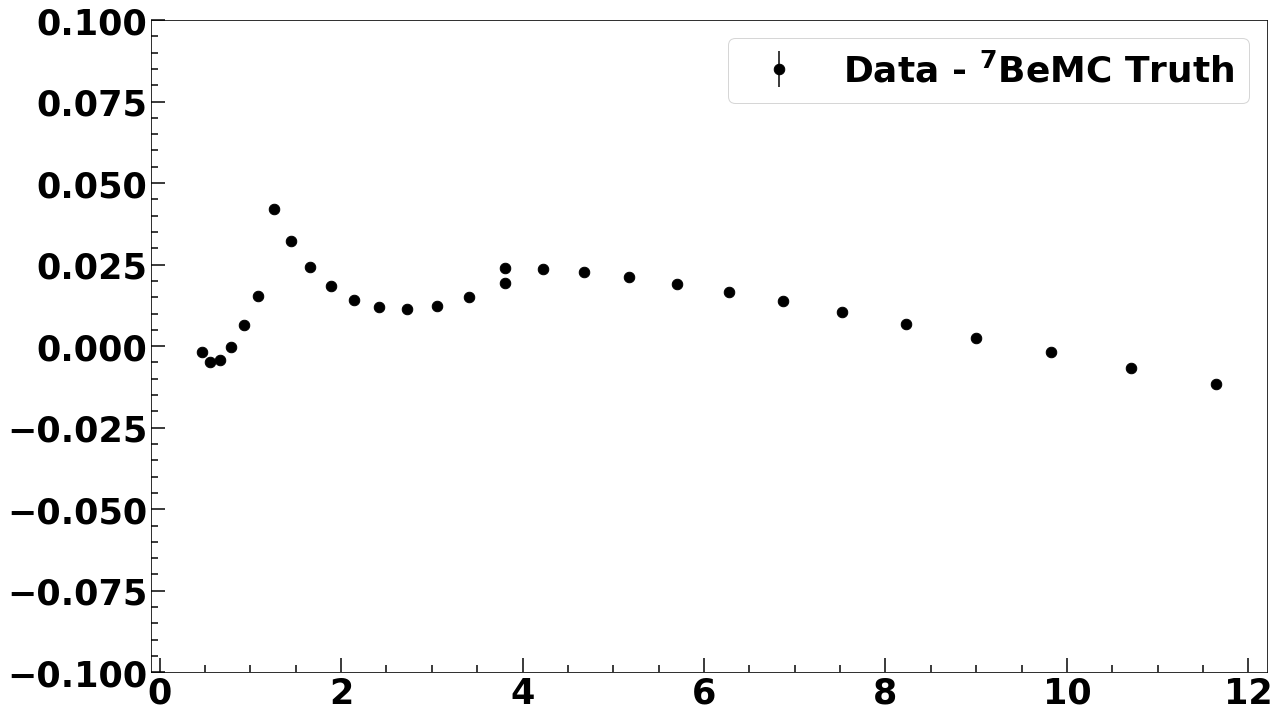

In [26]:
parname = 'mean'
parname_s = {'Tof': {'mean': 'mua', 'sigma':'siga' , 'fraccore': 'fraccore', 'asy_factor': 'asy_factor_a', 'sigma_ratio': 'sigma_ratio_a'},                                                                                                   
            'NaF': {'mean': 'mua', 'sigma':'siga' , 'fraccore': 'fraccore', 'asy_factor': 'asy_factor', 'sigma_ratio': 'sigma_ratio'},                                                                                                       
            'Agl': {'mean': 'mua', 'sigma':'siga' , 'fraccore': 'fraccore_a', 'asy_factor': 'asy_factor_a', 'sigma_ratio': 'sigma_ratio_a'}}  
fitmcgausfile = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCMassGaus_Untuned'
graph_mean_gausfit = {dec: {} for dec in detectors}
graph_deltamass_gausfit = {dec: {} for dec in detectors}
subgraph_mean_gausfit = {dec: {} for dec in detectors}
RANGE_EKIN ={"Tof": [0.5, 1.1], "NaF": [1.2, 4.0], "Agl": [4.0, 12.0]}
with np.load(os.path.join(fitmcgausfile, "graph_gausfit_MCMass_Be.npz")) as dfile:
    for dec in detectors:
        for iso in isotopes:
            graph_mean_gausfit[dec][iso] = MGraph.from_file(dfile, f'graph_{dec}{iso}_mean')
            subgraph_mean_gausfit[dec][iso] = slice_graph_by_value(graph_mean_gausfit[dec][iso], massfit[dec].fit_energy_range)
    
subgraph_mean_true = {dec: {} for dec in detectors}
graph_mean_true  = {dec: {} for dec in detectors}
graph_mean_data = {}
with np.load("/home/manbing/Documents/lithiumanalysis/slides/plots/Study_energy_loss_mean/graph_truemass_mean.npz") as mufile:
    for dec in detectors:
        for iso in isotopes: 
            graph_mean_true[dec][iso] = MGraph.from_file(mufile, f'graph_truemass_mean_{dec}{iso}')
            subgraph_mean_true[dec][iso] = slice_graph_by_value(graph_mean_true[dec][iso], massfit[dec].fit_energy_range)
graph_diff_datamc = {}      
graph_diff_dataMCTrue = {}
fig, ax1 = plt.subplots(1, figsize=(20, 12))
for dec in detectors: 
    #graph_diff_datamc[dec] = subgraph_mean_gausfit[dec]['Be7']
    plot_graph(fig, ax1, subgraph_mean_gausfit[dec]['Be7'], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"{ISO_LABELS[iso]}MC {dec}" if dec=='Tof' else None)
    plot_graph(fig, ax1, subgraph_mean_true[dec]['Be7'], color='black', style="hist", xlog=False, ylog=False, scale=None, markersize=21, linewidth=2, label=f"MC Truth" if dec=='Tof' else None)

    par_index = massfit[dec].get_polypars_index()                                                                                                                                                                                             
    pindex_s = par_index[parname_s[dec][parname]]                                                                                                                                                                                             
    nparpoly = 3                                                                                                                                                                                           
    pindex_e = pindex_s + nparpoly   
    print(pindex_s, pindex_e)
    #xval = massfit[dec].x_fit_energy  
    xval = subgraph_mean_gausfit[dec]['Be7'].xvalues
    print(xval)
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), dict_results['Be7'][dec][pindex_s:pindex_e], upoly)  
    graph_mean_data[dec] = MGraph(xval, yfit, yfit_err)
    graph_diff_datamc[dec] = MGraph(xval, (1/graph_mean_data[dec].yvalues - 1/subgraph_mean_gausfit[dec]['Be7'].yvalues), np.zeros_like(xval))
    graph_diff_dataMCTrue[dec] = MGraph(xval, (1/graph_mean_data[dec].yvalues - 1/subgraph_mean_true[dec]['Be7'].yvalues), np.zeros_like(xval))
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), dict_results['Be7'][dec][pindex_s:pindex_e], upoly)  
    set_plot_style(ax1)
     
                                                                                                                                                                                                      
    fig.subplots_adjust(left= 0.13, right=0.95, bottom=0.1, top=0.95) 
    ax1.plot(xval, yfit, '-', color=DETECTOR_COLOR[dec], label=f'{dec} fit (Data)')  
    
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=DETECTOR_COLOR[dec], alpha=0.3)                                                                                                                                                      
    ax1.set_ylabel(r'$\mu(\mathrm{1/m})$')                                                                                                                                                                                                           
    ax1.set_xlabel('Ekin/N(GeV/n)')                                                                                                                                                                                                           
    ax1.set_ylim([0.14, 0.16])   
    ax1.axhline(y=1/ISOTOPES_MASS['Be7'], color='grey', linestyle='--', label='nominal inverse mass') 
    ax1.legend(loc="lower right", fontsize=30)                                                                                                                                                                                                
    #ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")  

fig, ax1 = plt.subplots(1, figsize=(20, 12))
for dec in detectors:
    #plot_graph(fig, ax1, slice_graph_by_value(graph_diff_datamc[dec], RANGE_EKIN[dec]), color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"Data - {ISO_LABELS['Be7']}MC GausFit" if dec=='Tof' else None)
    plot_graph(fig, ax1, slice_graph_by_value(graph_diff_dataMCTrue[dec], RANGE_EKIN[dec]), color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"Data - {ISO_LABELS['Be7']}MC Truth" if dec=='Tof' else None)
    ax1.set_ylim([-0.1, 0.1]) 
    ax1.legend()

0 3
[0.4631  0.559   0.66835 0.79125 0.9303  1.08555]
[0.00045509 0.00034169 0.00026294 0.00017365 0.00031068 0.00049956]
yfit_err: [0.0004125  0.00022855 0.00016651 0.0001679  0.00016113 0.00013966]
yfit: [0.15310259 0.15317314 0.15315643 0.15306576 0.15291045 0.15270009]
yfit_lower: [0.15269009 0.15294458 0.15298992 0.15289786 0.15274932 0.15256044]
diff: [4.25916308e-05 1.13136411e-04 9.64252858e-05 5.75770577e-06
 1.49546922e-04 3.59907195e-04]
0 3
[1.2571  1.44745 1.6566  1.8872  2.1419  2.42075 2.7237  3.0534  3.4126
 3.80125]
[0.00116262 0.00092196 0.00074992 0.00061711 0.00051476 0.00044859
 0.00042949 0.00047322 0.00059373 0.0007814 ]
yfit_err: [0.00020704 0.00018527 0.00018985 0.00019374 0.00018761 0.00017417
 0.00016667 0.00018611 0.0002444  0.00033576]
yfit: [0.15038115 0.15082899 0.15119108 0.1514789  0.15170032 0.15185988
 0.15196293 0.15201536 0.15202155 0.15198529]
yfit_lower: [0.15017411 0.15064373 0.15100123 0.15128516 0.15151271 0.15168571
 0.15179627 0.15182925 0.15

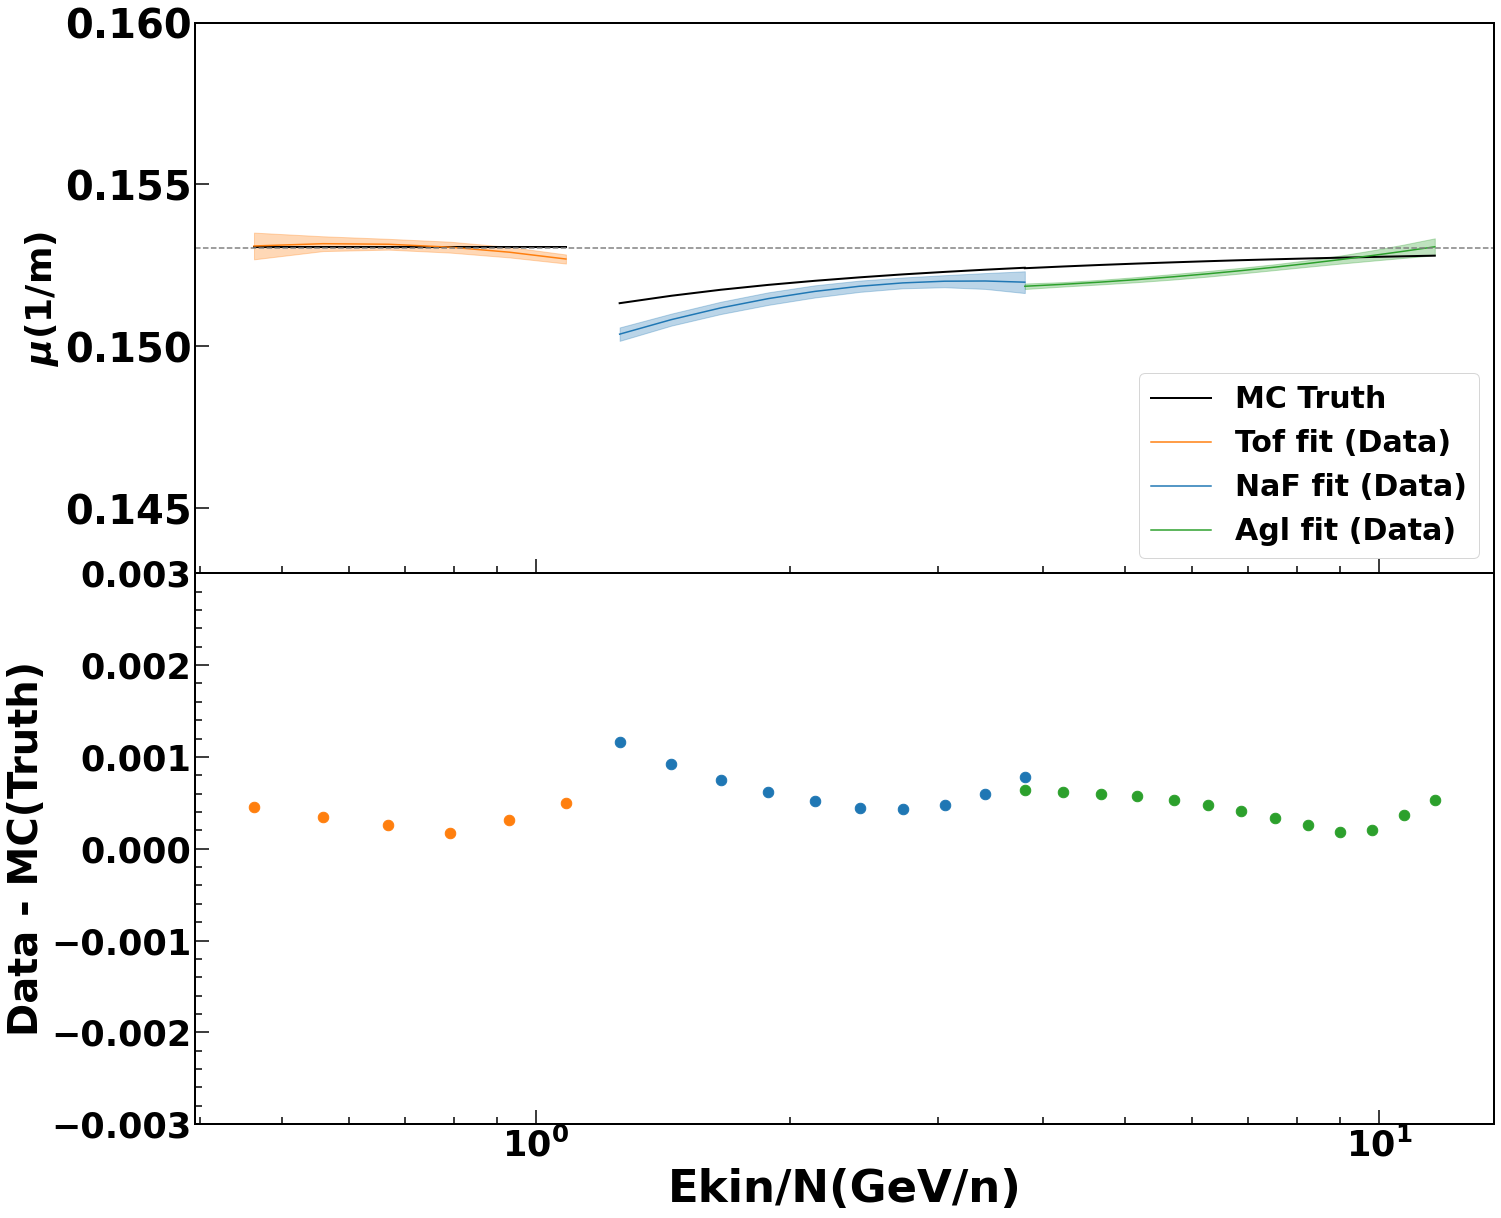

In [40]:
parname = 'mean'
parname_s = {'Tof': {'mean': 'mua', 'sigma':'siga' , 'fraccore': 'fraccore', 'asy_factor': 'asy_factor_a', 'sigma_ratio': 'sigma_ratio_a'},                                                                                                   
            'NaF': {'mean': 'mua', 'sigma':'siga' , 'fraccore': 'fraccore', 'asy_factor': 'asy_factor', 'sigma_ratio': 'sigma_ratio'},                                                                                                       
            'Agl': {'mean': 'mua', 'sigma':'siga' , 'fraccore': 'fraccore_a', 'asy_factor': 'asy_factor_a', 'sigma_ratio': 'sigma_ratio_a'}}  
fitmcgausfile = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCMassGaus_Untuned'
graph_mean_gausfit = {dec: {} for dec in detectors}
graph_deltamass_gausfit = {dec: {} for dec in detectors}
subgraph_mean_gausfit = {dec: {} for dec in detectors}
with np.load(os.path.join(fitmcgausfile, "graph_gausfit_MCMass_Be.npz")) as dfile:
    for dec in detectors:
        for iso in isotopes:
            graph_mean_gausfit[dec][iso] = MGraph.from_file(dfile, f'graph_{dec}{iso}_mean')
            subgraph_mean_gausfit[dec][iso] = slice_graph_by_value(graph_mean_gausfit[dec][iso], massfit[dec].fit_energy_range)
    
subgraph_mean_true = {dec: {} for dec in detectors}
with np.load("/home/manbing/Documents/lithiumanalysis/slides/plots/Study_energy_loss_mean/graph_truemass_mean.npz") as mufile:
    for dec in detectors:
        for iso in isotopes: 
            graph_mean_true[dec][iso] = MGraph.from_file(mufile, f'graph_truemass_mean_{dec}{iso}')
            subgraph_mean_true[dec][iso] = slice_graph_by_value(graph_mean_true[dec][iso], massfit[dec].fit_energy_range)

graph_fitdata_mean = {}
graph_difference_mean = {}
graph_lowdifference_mean = {}
graph_updifference_mean = {}
graph_maxdifference_mean = {}
graph_ratio_mean = {}

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(22, 18))

for dec in detectors:   
    #plot_graph(fig, ax1, subgraph_mean_gausfit[dec]['Be7'], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"{ISO_LABELS[iso]}MC {dec}" if dec=='Tof' else None)
    plot_graph(fig, ax1, subgraph_mean_true[dec]['Be7'], color='black', style="hist", xlog=False, ylog=False, scale=None, markersize=21, linewidth=2, label=f"MC Truth" if dec=='Tof' else None)
    par_index = massfit[dec].get_polypars_index()  
    set_plot_style(ax1)
    set_plot_style(ax2)
    pindex_s = par_index[parname_s[dec][parname]]                                                                                                                                                                                             
    nparpoly = 3                                                                                                                                                                                           
    pindex_e = pindex_s + nparpoly   
    print(pindex_s, pindex_e)
    #xval = massfit[dec].x_fit_energy  
    xval = subgraph_mean_true[dec]['Be7'].xvalues
    print(xval)
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), dict_results['Be7'][dec][pindex_s:pindex_e], upoly)  
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), dict_results['Be7'][dec][pindex_s:pindex_e], upoly)  
    graph_fitdata_mean[dec] = MGraph(xval, yfit, yfit_err)
    
    difflow = abs(yfit_lower - subgraph_mean_true[dec]['Be7'].yvalues)
    diffup  = abs(yfit_upper - subgraph_mean_true[dec]['Be7'].yvalues)
    diff =  abs(graph_fitdata_mean[dec].yvalues - subgraph_mean_true[dec]['Be7'].yvalues)
    print(np.maximum(difflow, diffup))
    print('yfit_err:', yfit_err)
    print('yfit:', yfit)
    print('yfit_lower:', yfit_lower)
    print('diff:', diff)
    graph_difference_mean[dec] = MGraph(graph_fitdata_mean[dec].xvalues, np.maximum.reduce([difflow, diffup, diff]), np.zeros_like(graph_fitdata_mean[dec].xvalues))
    graph_ratio_mean[dec] = graph_fitdata_mean[dec]/subgraph_mean_true[dec]['Be7']                                                                                                                                                                                                
    fig.subplots_adjust(left= 0.13, right=0.95, bottom=0.1, top=0.95) 
    ax1.plot(xval, yfit, '-', color=DETECTOR_COLOR[dec], label=f'{dec} fit (Data)')                                                                                                                                                                                                                                                                        
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=DETECTOR_COLOR[dec], alpha=0.3)    
    
    ax1.set_xticklabels([])
    ax2.set_xlabel("Ekin/n (GeV/n)", fontsize=fontsize1)   
    ax2.set_ylabel('Data - MC(Truth)', fontsize=40)
    ax2.set_xticks([0.4, 1, 2, 3, 5, 10]) 
    ax2.set_xscale('log')
    ax2.set_ylim([-0.003, 0.003])
    ax1.sharex(ax2)
    plt.subplots_adjust(hspace=.0)
    
    ax1.set_ylabel(r'$\mu(\mathrm{1/m})$')                                                                                                                                                                                                                                                                                                                                                                                                                
    ax1.set_ylim([0.143, 0.16])   
    
    ax1.legend(loc="lower right", fontsize=30) 
    ax2.set_xlabel('Ekin/N(GeV/n)') 
    plot_graph(fig, ax2, graph_difference_mean[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, linewidth=2, label=f"MC Truth" if dec=='Tof' else None)
    
    #ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")  

ax1.axhline(y=1/ISOTOPES_MASS['Be7'], color='grey', linestyle='--', label='nominal inverse mass') 
#ax2.axhline(y=1.0, color='grey', linestyle='--') 
#ax2.axhline(y=1.01, color='grey', linestyle='--') 
#ax2.axhline(y=0.99, color='grey', linestyle='--') 




0 3
[0.4631  0.559   0.66835 0.79125 0.9303  1.08555]
[0.00045509 0.00034169 0.00026294 0.00017365 0.00031068 0.00049956]
yfit_err: [0.0004125  0.00022855 0.00016651 0.0001679  0.00016113 0.00013966]
yfit: [0.15310259 0.15317314 0.15315643 0.15306576 0.15291045 0.15270009]
yfit_lower: [0.15269009 0.15294458 0.15298992 0.15289786 0.15274932 0.15256044]
diff: [4.25916308e-05 1.13136411e-04 9.64252858e-05 5.75770577e-06
 1.49546922e-04 3.59907195e-04]
0 3
[1.2571  1.44745 1.6566  1.8872  2.1419  2.42075 2.7237  3.0534  3.4126
 3.80125]
[0.00116262 0.00092196 0.00074992 0.00061711 0.00051476 0.00044859
 0.00042949 0.00047322 0.00059373 0.0007814 ]
yfit_err: [0.00020704 0.00018527 0.00018985 0.00019374 0.00018761 0.00017417
 0.00016667 0.00018611 0.0002444  0.00033576]
yfit: [0.15038115 0.15082899 0.15119108 0.1514789  0.15170032 0.15185988
 0.15196293 0.15201536 0.15202155 0.15198529]
yfit_lower: [0.15017411 0.15064373 0.15100123 0.15128516 0.15151271 0.15168571
 0.15179627 0.15182925 0.15

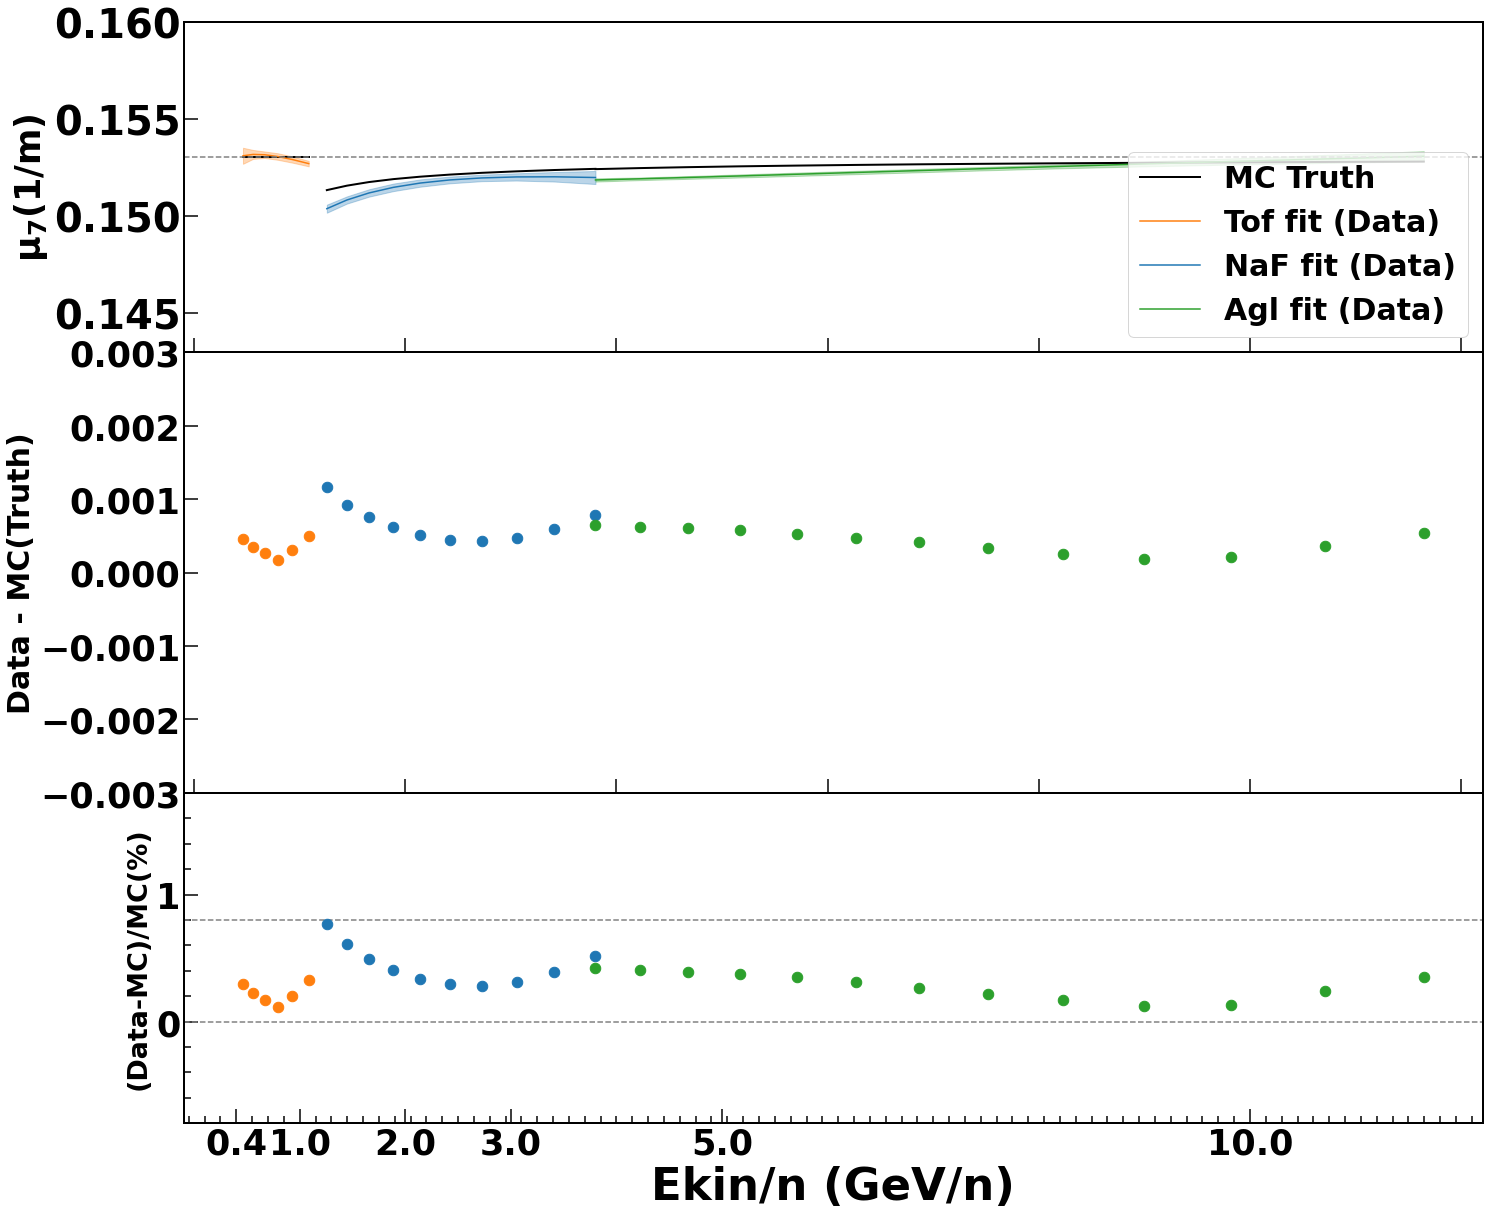

In [72]:
parname = 'mean'
parname_s = {'Tof': {'mean': 'mua', 'sigma':'siga' , 'fraccore': 'fraccore', 'asy_factor': 'asy_factor_a', 'sigma_ratio': 'sigma_ratio_a'},                                                                                                   
            'NaF': {'mean': 'mua', 'sigma':'siga' , 'fraccore': 'fraccore', 'asy_factor': 'asy_factor', 'sigma_ratio': 'sigma_ratio'},                                                                                                       
            'Agl': {'mean': 'mua', 'sigma':'siga' , 'fraccore': 'fraccore_a', 'asy_factor': 'asy_factor_a', 'sigma_ratio': 'sigma_ratio_a'}}  
fitmcgausfile = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCMassGaus_Untuned'
graph_mean_gausfit = {dec: {} for dec in detectors}
graph_deltamass_gausfit = {dec: {} for dec in detectors}
subgraph_mean_gausfit = {dec: {} for dec in detectors}
with np.load(os.path.join(fitmcgausfile, "graph_gausfit_MCMass_Be.npz")) as dfile:
    for dec in detectors:
        for iso in isotopes:
            graph_mean_gausfit[dec][iso] = MGraph.from_file(dfile, f'graph_{dec}{iso}_mean')
            subgraph_mean_gausfit[dec][iso] = slice_graph_by_value(graph_mean_gausfit[dec][iso], massfit[dec].fit_energy_range)
    
subgraph_mean_true = {dec: {} for dec in detectors}
with np.load("/home/manbing/Documents/lithiumanalysis/slides/plots/Study_energy_loss_mean/graph_truemass_mean.npz") as mufile:
    for dec in detectors:
        for iso in isotopes: 
            graph_mean_true[dec][iso] = MGraph.from_file(mufile, f'graph_truemass_mean_{dec}{iso}')
            subgraph_mean_true[dec][iso] = slice_graph_by_value(graph_mean_true[dec][iso], massfit[dec].fit_energy_range)

graph_fitdata_mean = {}
graph_difference_mean = {}
graph_lowdifference_mean = {}
graph_updifference_mean = {}
graph_maxdifference_mean = {}
graph_ratio_mean = {}

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.4, 0.3, 0.3]}, figsize=(22, 18))

for dec in detectors:   
    #plot_graph(fig, ax1, subgraph_mean_gausfit[dec]['Be7'], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"{ISO_LABELS[iso]}MC {dec}" if dec=='Tof' else None)
    plot_graph(fig, ax1, subgraph_mean_true[dec]['Be7'], color='black', style="hist", xlog=False, ylog=False, scale=None, markersize=21, linewidth=2, label=f"MC Truth" if dec=='Tof' else None)
    par_index = massfit[dec].get_polypars_index()  
    set_plot_style(ax1)
    set_plot_style(ax2)
    set_plot_style(ax3)
    pindex_s = par_index[parname_s[dec][parname]]                                                                                                                                                                                             
    nparpoly = 3                                                                                                                                                                                           
    pindex_e = pindex_s + nparpoly   
    print(pindex_s, pindex_e)
    #xval = massfit[dec].x_fit_energy  
    xval = subgraph_mean_true[dec]['Be7'].xvalues
    print(xval)
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), dict_results['Be7'][dec][pindex_s:pindex_e], upoly)  
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), dict_results['Be7'][dec][pindex_s:pindex_e], upoly)  
    graph_fitdata_mean[dec] = MGraph(xval, yfit, yfit_err)
    
    difflow = abs(yfit_lower - subgraph_mean_true[dec]['Be7'].yvalues)
    diffup  = abs(yfit_upper - subgraph_mean_true[dec]['Be7'].yvalues)
    diff =  abs(graph_fitdata_mean[dec].yvalues - subgraph_mean_true[dec]['Be7'].yvalues)
    print(np.maximum(difflow, diffup))
    print('yfit_err:', yfit_err)
    print('yfit:', yfit)
    print('yfit_lower:', yfit_lower)
    print('diff:', diff)
    graph_difference_mean[dec] = MGraph(graph_fitdata_mean[dec].xvalues, np.maximum.reduce([difflow, diffup, diff]), np.zeros_like(graph_fitdata_mean[dec].xvalues))
    graph_ratio_mean[dec] = graph_difference_mean[dec]/subgraph_mean_true[dec]['Be7']  
    graph_ratio_mean[dec].yvalues = graph_ratio_mean[dec].yvalues * 100
    fig.subplots_adjust(left= 0.13, right=0.95, bottom=0.1, top=0.95) 
    ax1.plot(xval, yfit, '-', color=DETECTOR_COLOR[dec], label=f'{dec} fit (Data)')                                                                                                                                                                                                                                                                        
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=DETECTOR_COLOR[dec], alpha=0.3)    
    
    ax1.set_xticklabels([])
    ax2.set_ylabel('Data - MC(Truth)', fontsize=30)
    ax2.set_ylim([-0.003, 0.003])
    ax3.set_ylabel('(Data-MC)/MC(%)', fontsize=27)
    ax3.set_xlabel("Ekin/n (GeV/n)", fontsize=fontsize1)       
    ax3.set_xticks([0.4, 1, 2, 3, 5, 10]) 
    ax3.set_ylim([-0.8, 1.8])
    #ax3.set_xscale('log')

    ax1.sharex(ax2)
    plt.subplots_adjust(hspace=.0)
    
    ax1.set_ylabel(r'$\mathrm{\mu_{7} (\mathrm{1/m})}$', fontsize=35)                                                                                                                                                                                                                                                                                                                                                                                                                
    ax1.set_ylim([0.143, 0.16])   
    
    ax1.legend(loc="lower right", fontsize=30)  
    plot_graph(fig, ax2, graph_difference_mean[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, linewidth=2, label=f"MC Truth" if dec=='Tof' else None)
    plot_graph(fig, ax3, graph_ratio_mean[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, linewidth=2, label=f"MC Truth" if dec=='Tof' else None)
    #ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")  

ax1.axhline(y=1/ISOTOPES_MASS['Be7'], color='grey', linestyle='--', label='nominal inverse mass') 
ax3.axhline(y=0.8, color='grey', linestyle='--') 
ax3.axhline(y=0.0, color='grey', linestyle='--') 
#ax2.axhline(y=0.99, color='grey', linestyle='--') 
savefig_tofile(fig, plotfile, 'mass_compare_datamc', 1)


In [41]:
def GetFitValueLim(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fit_lower, fit_upper = get_fitpdferrorband(np.log(graph1.xvalues), polypars, upoly)
    return fit_lower, fit_upper

def get_uncertainty_spline(graphlow, graphup):
    xvector = graphlow.xvalues
    yvector = ((graphup.yvalues - graphlow.yvalues)/2)/((graphup.yvalues + graphlow.yvalues)/2)
    spline_fit = UnivariateSpline(np.log(xvector), yvector, k=3, s=5)
    return spline_fit

def GetFitValue(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fity, fityerr = get_fitpdf_witherr(np.log(graph1.xvalues), polypars, upoly)
    graph_fit = MGraph(graph1.xvalues, fity, fityerr)
    return graph_fit

def getgraph_errband(graph1, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_fitlow = MGraph(graph1.xvalues,fit_lower1, np.zeros_like(fit_lower1))
    graph_fitup = MGraph(graph1.xvalues,fit_upper1, np.zeros_like(fit_upper1))
    return graph_fitlow, graph_fitup

def getgrapherr(graph1,  parname, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_err = MGraph(graph1.xvalues, err1, np.zeros_like(fit_upper1))
    return graph_err

def getgrapherr_fromLowUp(graphlow,  graphup):
    err= (graphup.yvalues - graphlow.yvalues)/2 
    graph_err = MGraph(graphlow.xvalues, err, np.zeros_like(err))
    return graph_err

def calculate_graph_ratioerrs(graph1, graph2, corelation):
    a = graph1.yvalues
    b = graph2.yvalues
    erra = graph1.yerrs
    errb = graph2.yerrs
    print(1/a**2 * erra**2 + 1/b**2 * errb**2 - 2 * abs(corelation * erra * errb/(a * b)))
    yerrs = (a/b) * np.sqrt(1/a**2 * erra**2 + 1/b**2 * errb**2 - 2 * abs(corelation * erra * errb/(a * b)))          
    return yerrs


xvalues			yvalues			yerrs
0.4631			0.9997900836900969			0.0008438242590199652
0.5589999999999999			0.9997900836900968			0.0006340258759289785
0.66835			0.9997900839838462			0.00048814512793404763
0.79125			0.9997900840798424			0.0003225808818978493
0.9302999999999999			0.9997900842831144			0.0005765971209588105
1.08555			0.9997900885604802			0.0009260218600948278


xvalues			yvalues			yerrs
1.2570999999999999			1.0024730314831487			0.002149628255720293
1.44745			1.0021364861080615			0.001706820367095574
1.6566			1.0018662677846606			0.0013895372779000326
1.8872			1.0016481971007067			0.0011441884946985503
2.1419			1.001464814766351			0.0009549027496027485
2.42075			1.0013148585157126			0.0008323806165886349
2.7237			1.0011786956724236			0.0007969409631451985
3.0534			1.001074555970701			0.0008777083410640429
3.4126000000000003			1.0009723598041813			0.0011002616007487198
3.8012500000000005			1.0008840411137707			0.0014461507140604013


xvalues			yvalues			yerrs
3.8012500000000005			1.

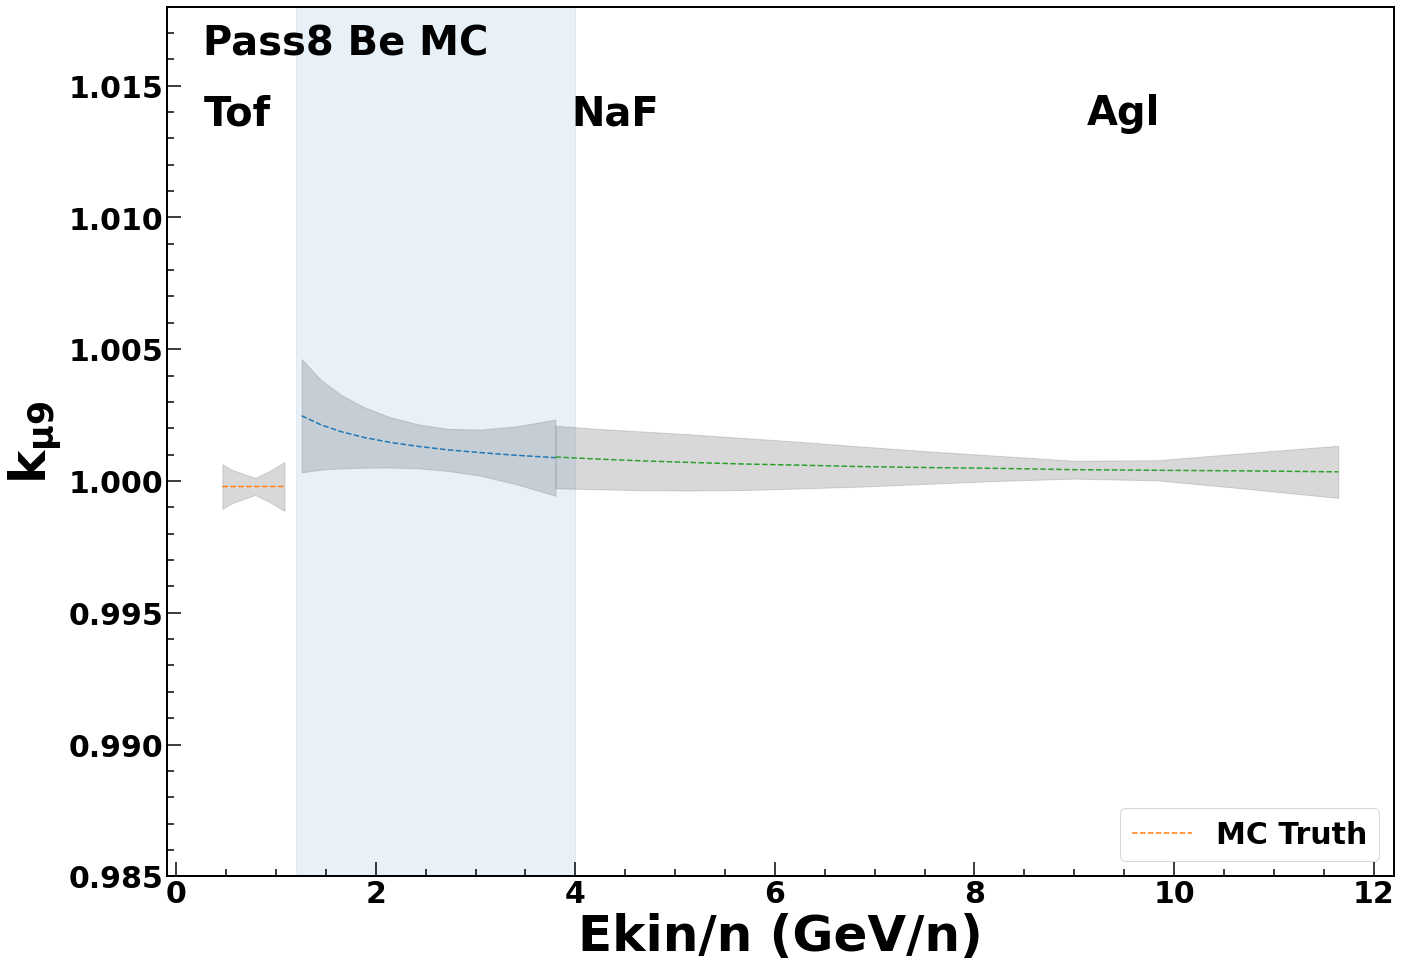

In [67]:
massratiobe9 = {}
massratiobe10 = {}
graph_massratio_be9 = {}
graph_massratio_be10 = {}

graph_massratio_be9_data = {}
graph_massratio_be10_data = {}
graph_fitdata_mean_Be9 = {}
graph_fitdata_mean_Be7 = {}

graph_massratio_be9_newerr = {}
graph_massratio_be9up = {}
graph_massratio_be10low = {}
graph_massratio_be10up = {}

graph_fitdata_mean_Be10 = {}

dfname = {dec: f'/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitmassgaus/df_mean_ratio_{dec}.npz' for dec in detectors}
#filename = filecounts_path + 'df_ratio_mean_iter2.npz'
dfgausfit = {dec:  np.load(f'{dfname[dec]}') for dec in detectors}
#dffit = np.load(f'{filename}')

slicevalue_trueratio = {'Tof':[0.5, 1.2], 'NaF':[1.2, 4.0], 'Agl':[4.0, 12.0]}
slicevalue_recratio = {'Tof':[0.5, 1.2], 'NaF':[1.2, 4.0], 'Agl':[4.0, 12.0]}
RANGE_EKIN ={"Tof": [0.5, 1.1], "NaF": [1.2, 4.0], "Agl": [4.0, 12.0]}

from tools.constants import ISOTOPES_MASS
for dec in detectors:
    #massratiobe9[dec] = (1/ISOTOPES_MASS['Be9'] - deltamass[dec]['Be9'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be9[dec] = subgraph_mean_true[dec]['Be9']/subgraph_mean_true[dec]['Be7']
    graph_massratio_be10[dec] = subgraph_mean_true[dec]['Be10']/subgraph_mean_true[dec]['Be7']
    graph_massratio_be9[dec] = slice_graph_by_value(graph_massratio_be9[dec], slicevalue_trueratio[dec])
    graph_massratio_be10[dec] = slice_graph_by_value(graph_massratio_be10[dec], slicevalue_trueratio[dec])
    graph_massratio_be9[dec].yvalues = graph_massratio_be9[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be10[dec].yvalues = graph_massratio_be10[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10']) 
    
    graph_fitdata_mean_Be9[dec] = MGraph(subgraph_mean_true[dec]['Be9'].xvalues, subgraph_mean_true[dec]['Be9'].yvalues + graph_difference_mean[dec].yvalues,  subgraph_mean_true[dec]['Be9'].yerrs)
    graph_fitdata_mean_Be7[dec] = MGraph(subgraph_mean_true[dec]['Be7'].xvalues, subgraph_mean_true[dec]['Be7'].yvalues + graph_difference_mean[dec].yvalues,  subgraph_mean_true[dec]['Be7'].yerrs)
    graph_massratio_be9_data[dec] = graph_fitdata_mean_Be9[dec]/graph_fitdata_mean_Be7[dec]
    graph_massratio_be10_data[dec] = subgraph_mean_true[dec]['Be10']/graph_fitdata_mean[dec]
    graph_massratio_be9_data[dec] = slice_graph_by_value(graph_massratio_be9_data[dec], slicevalue_trueratio[dec])
    graph_massratio_be10_data[dec] = slice_graph_by_value(graph_massratio_be10_data[dec], slicevalue_trueratio[dec])
    graph_massratio_be9_data[dec].yvalues = graph_massratio_be9_data[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be10[dec].yvalues = graph_massratio_be10_data[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10']) 
    
    graph_massratio_be9_newerr[dec] =  MGraph(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, abs(graph_massratio_be9_data[dec].yvalues - graph_massratio_be9[dec].yvalues))
    
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[1.0], 'NaF':[1.0, 0.1, 0.1], "Agl":[1.0, 0.1, 0.1]}
dict_polypars_mufactor = {dec: {} for dec in detectors}
graphfitku_low = {}
graphfitku_up = {}
graphfitku_maxlow = {}
graphfitku_maxup = {}

graphfitku = {}
graph_diff_TrueReco = {}
spline_ku_uncertainty = {}
for dec in detectors:

    #plot_graph(fig, ax1, graph_massratio_be9_data[dec], color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Truth")
    ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '--', color=DETECTOR_COLOR[dec], label=f'MC Truth' if dec =='Tof' else None)
    if dec == 'Tof':
        
       
        ax1.text(xaxistext[dec], 0.98, f"Pass8 Be MC", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")   
        ax1.text(xaxistext[dec], 0.9, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
    else:
    
        ax1.text(xaxistext[dec], 0.9, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
        
    
    #graph_diff_TrueReco[dec] = MGraph(graph_massratio_be9[dec].xvalues, graphfitku[dec].yvalues - graph_massratio_be9[dec].yvalues, np.zeros_like(graph_massratio_be9[dec].xvalues))
    print(graph_massratio_be9_newerr[dec])
    ax1.fill_between(graph_massratio_be9_newerr[dec].xvalues, graph_massratio_be9_newerr[dec].yvalues-graph_massratio_be9_newerr[dec].yerrs, graph_massratio_be9_newerr[dec].yvalues+graph_massratio_be9_newerr[dec].yerrs,  color='grey', alpha=0.3)
    #ax1.fill_between(graphfitku_low[dec].xvalues, graphfitku_up[dec].yvalues, graphfitku_up[dec].yvalues + graph_diff_TrueReco[dec].yvalues,  color='grey', alpha=0.3, label=r'uncertainty from deviation from MC Truth' if dec == 'Tof' else None)
    #graphfitku_maxlow[dec] = MGraph(graphfitku_low[dec].xvalues, graphfitku_low[dec].yvalues-graph_diff_TrueReco[dec].yvalues, np.zeros_like(graphfitku_low[dec].xvalues))
    #graphfitku_maxup[dec] = MGraph(graphfitku_up[dec].xvalues, graphfitku_up[dec].yvalues+ graph_diff_TrueReco[dec].yvalues, np.zeros_like(graphfitku_up[dec].xvalues))
    #spline_ku_uncertainty[dec] = get_uncertainty_spline(graphfitku_maxlow[dec], graphfitku_maxup[dec] )
    

#with open('/home/manbing/Documents/Data/data_BeP8/spline_ku_uncertainty.pickle', 'wb') as file:
#    pickle.dump(spline_ku_uncertainty, file)
#with open('/home/manbing/Documents/Data/data_BeP8/spline_ku_uncertainty.pickle', 'rb') as file:
#    loadfile = pickle.load(file)
#    print(loadfile.items())    

set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)", fontsize=50) 
ax1.set_ylabel(r'$\mathrm{k_{\mu9}}$', fontsize=50)
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.97, 1.03, 100), 1.2, 4.0, alpha=0.1, color="tab:blue") 
ax1.set_ylim([0.985, 1.018])
ax1.legend(loc='lower right')
#ax1.legend(loc='lower right', fontsize=35)

savefig_tofile(fig, plotfile, 'mass_meanbe9correction', 1)
   